In [2]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00


In [3]:
import matplotlib.pylab as plt
import os
import numpy as np
import random
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow import keras
from keras_tuner import RandomSearch, HyperParameters

import warnings
warnings.filterwarnings('ignore')



In [4]:
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)


#Loading Data

In [5]:
from os.path import split
datasets, info = tfds.load(name = 'beans', with_info = True, as_supervised = True, split = ['train','test', 'validation'])


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1034 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/incomplete.HBRPOI_0.1.0/beans-train.tfrecord*...:   0%|          | 0…

Generating validation examples...:   0%|          | 0/133 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/incomplete.HBRPOI_0.1.0/beans-validation.tfrecord*...:   0%|        …

Generating test examples...:   0%|          | 0/128 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/incomplete.HBRPOI_0.1.0/beans-test.tfrecord*...:   0%|          | 0/…

Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


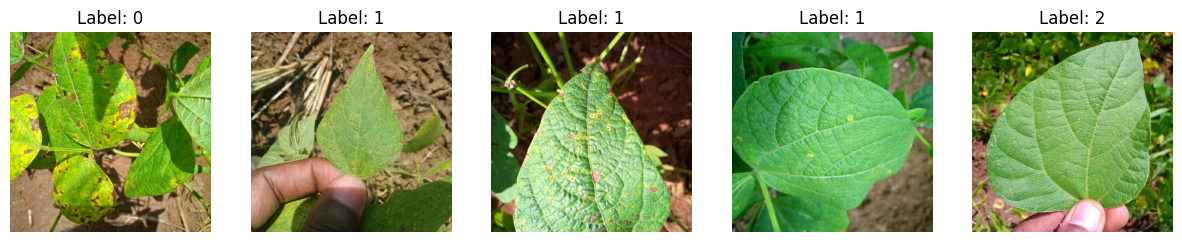

In [6]:
dataset, info = tfds.load(name='beans', with_info=True, split='test')

num_examples = 5

fig, axes = plt.subplots(1, num_examples, figsize=(15, 5))

for i, example in enumerate(dataset.take(num_examples)):
    image = example['image'].numpy()
    label = example['label'].numpy()

    axes[i].imshow(image)
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.show()


#Preprocessing

In [7]:
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.0
    return tf.image.resize(image, (224, 224)), tf.one_hot(label, 3)

In [8]:
def get_dataset(batch_size = 32):
  train_dataset = datasets[0].map(scale).shuffle(1000).batch(batch_size)
  test_dataset = datasets[1].map(scale).batch(batch_size)
  validation_dataset = datasets[2].map(scale).batch(batch_size)
  return train_dataset, test_dataset, validation_dataset

In [9]:
train_ds, test_ds, val_ds = get_dataset()

In [10]:
img_size = (224, 224)
input_shape = (224, 224,3)

#Hyperparameter Tuning

In [12]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [13]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=(224, 224, 3), trainable=False)

In [14]:
# Define the hypermodel
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(feature_extractor_layer)
    model.add(tf.keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))

    model.compile(optimizer=keras.optimizers.Adam( hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),loss='categorical_crossentropy',metrics=['accuracy'])

    return model



In [20]:
tuner = RandomSearch(build_model,objective='val_accuracy',max_trials=5,executions_per_trial=3,directory='direc',project_name='leaf')



early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)

tuner.search(train_ds,epochs=10, validation_data=val_ds,callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the first densely-connected layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")




Trial 5 Complete [00h 01m 38s]
val_accuracy: 0.8696741660435995

Best val_accuracy So Far: 0.9248120188713074
Total elapsed time: 00h 08m 15s

The optimal number of units in the first densely-connected layer is 320 and the optimal learning rate for the optimizer
is 0.001.



In [21]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_ds, epochs=16, validation_data=val_ds,callbacks=[early_stopping])

Epoch 1/16
33/33 [==============================] - 5s 69ms/step - loss: 0.5301 - accuracy: 0.7940 - val_loss: 0.2657 - val_accuracy: 0.9023
Epoch 2/16
33/33 [==============================] - 2s 51ms/step - loss: 0.2418 - accuracy: 0.9043 - val_loss: 0.2916 - val_accuracy: 0.8722
Epoch 3/16
33/33 [==============================] - 2s 48ms/step - loss: 0.1637 - accuracy: 0.9381 - val_loss: 0.2387 - val_accuracy: 0.8947
Epoch 4/16
33/33 [==============================] - 2s 51ms/step - loss: 0.1170 - accuracy: 0.9642 - val_loss: 0.3867 - val_accuracy: 0.8271
Epoch 5/16
33/33 [==============================] - 3s 54ms/step - loss: 0.1197 - accuracy: 0.9584 - val_loss: 0.3294 - val_accuracy: 0.8797
Epoch 6/16
33/33 [==============================] - 2s 51ms/step - loss: 0.0530 - accuracy: 0.9884 - val_loss: 0.1838 - val_accuracy: 0.9173
Epoch 7/16
33/33 [==============================] - 2s 47ms/step - loss: 0.0506 - accuracy: 0.9874 - val_loss: 0.2206 - val_accuracy: 0.9023
Epoch 8/16
33

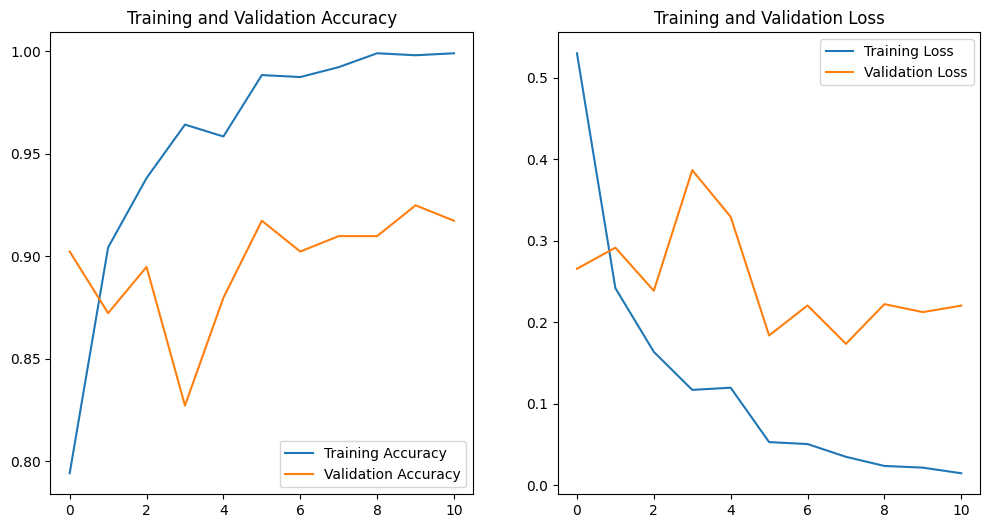

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

#Testing

1/1 [==============================] - 0s 471ms/step
[[9.9730432e-01 2.6955917e-03 1.5988368e-07]]


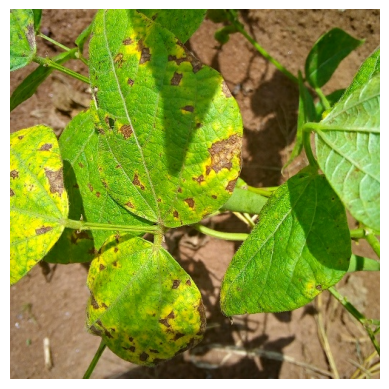

Actual Label: angular_leaf_spot
Predicted Label: angular_leaf_spot
1/1 [==============================] - 0s 27ms/step
[[5.5127713e-04 9.9933892e-01 1.0974678e-04]]


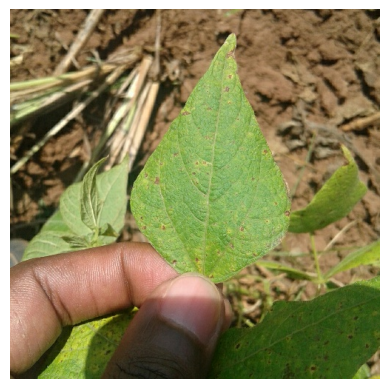

Actual Label: bean_rust
Predicted Label: bean_rust
1/1 [==============================] - 0s 24ms/step
[[0.34269068 0.65413976 0.00316954]]


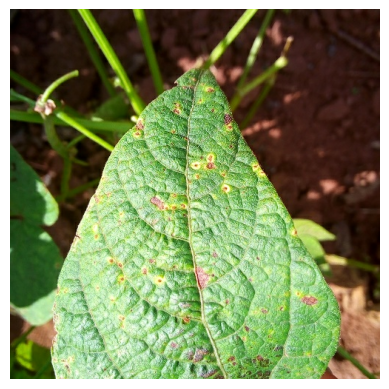

Actual Label: bean_rust
Predicted Label: bean_rust
1/1 [==============================] - 0s 48ms/step
[[0.00266675 0.07105572 0.9262775 ]]


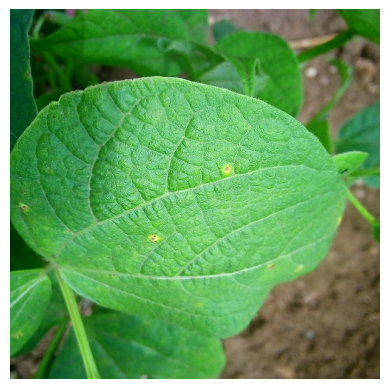

Actual Label: bean_rust
Predicted Label: healthy
1/1 [==============================] - 0s 52ms/step
[[3.4835755e-06 7.4641343e-05 9.9992192e-01]]


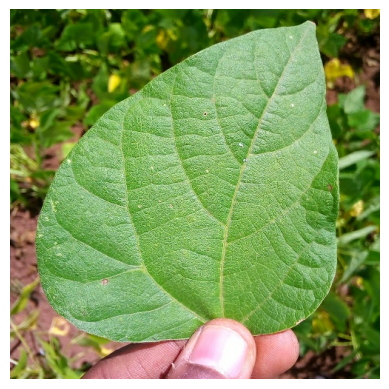

Actual Label: healthy
Predicted Label: healthy
1/1 [==============================] - 0s 41ms/step
[[9.7621268e-01 2.3622612e-02 1.6482821e-04]]


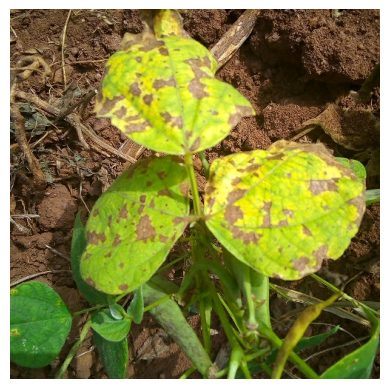

Actual Label: angular_leaf_spot
Predicted Label: angular_leaf_spot
1/1 [==============================] - 0s 31ms/step
[[9.8302052e-04 9.9833196e-01 6.8506453e-04]]


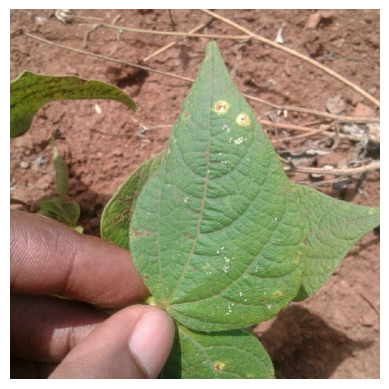

Actual Label: bean_rust
Predicted Label: bean_rust
1/1 [==============================] - 0s 43ms/step
[[9.9959844e-01 4.0141057e-04 6.3404826e-08]]


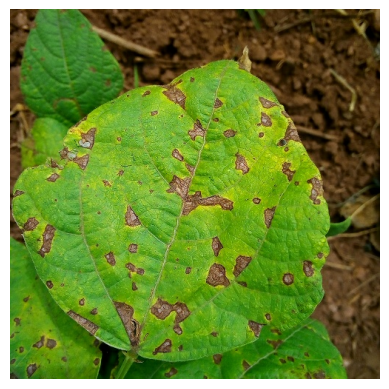

Actual Label: angular_leaf_spot
Predicted Label: angular_leaf_spot
1/1 [==============================] - 0s 32ms/step
[[9.565077e-01 4.341628e-02 7.608654e-05]]


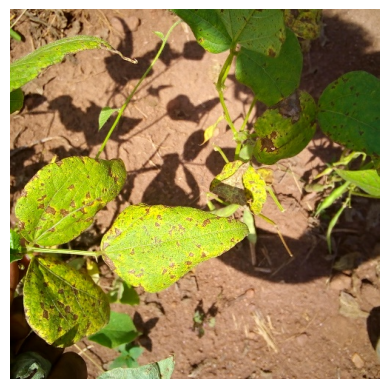

Actual Label: angular_leaf_spot
Predicted Label: angular_leaf_spot
1/1 [==============================] - 0s 31ms/step
[[0.00264952 0.9878036  0.00954687]]


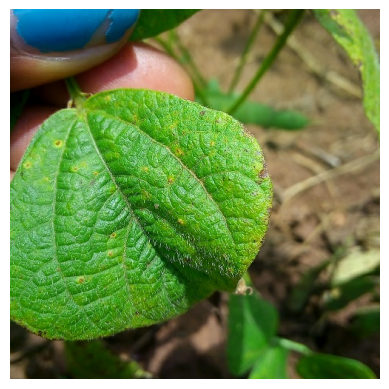

Actual Label: bean_rust
Predicted Label: bean_rust


In [23]:
for test_sample in datasets[1].take(10):
    image, label = test_sample[0], test_sample[1]
    image_scaled, label_arr = scale(image, label)
    image_batch = tf.expand_dims(image_scaled, axis=0)

    img = tf.keras.preprocessing.image.array_to_img(image)
    pred = model.predict(image_batch)
    print(pred)
    plt.figure
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print("Actual Label: %s" % info.features['label'].names[label.numpy()])
    print("Predicted Label: %s" % info.features['label'].names[np.argmax(pred)])


1/1 [==============================] - 0s 36ms/step


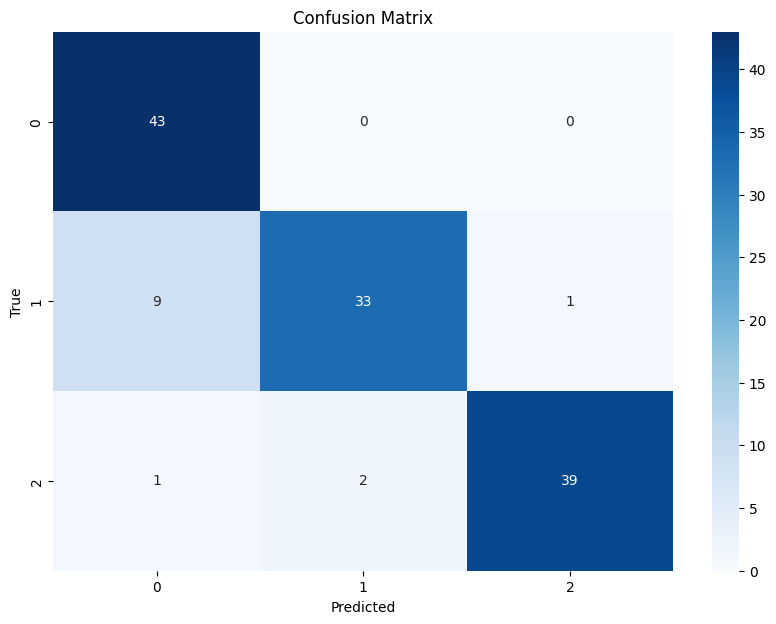

Accuracy: 0.8984375
Precision: 0.9092160124663073
Recall: 0.8984375
F1 Score: 0.8973177205479989


In [24]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score
import seaborn as sns



true_labels = []
predicted_labels = []

for features, labels in test_ds:
    true_labels_batch = np.argmax(labels, axis=1)
    predicted_labels_batch = np.argmax(model.predict(features), axis=1)
    true_labels.extend(true_labels_batch)
    predicted_labels.extend(predicted_labels_batch)

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

confusion_mat = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=range(3), yticklabels=range(3))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
